In [1]:
%matplotlib inline

from ROOT import TFile,vector,TGraph
import ROOT
import matplotlib.pyplot as plt
import pickle
import pandas as pd

import numpy as np
from numpy import mean
from math import sqrt,acos,cos,sin,pi,exp,log,isnan,atan2
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from numpy import asarray
from root_pandas import read_root
from matplotlib import gridspec
from scipy import stats

Welcome to JupyROOT 6.14/08


In [2]:
def bless_tune1_reweight(row):
    rw = float(1)
    if row['nu_interaction_mode']==1001 and (row['nu_pdg']==14 or row['nu_pdg']==-14):
        rw = xsec_tune1_graph_numu.Eval(row['MC_energyInit']) / xsec_mcc9_graph_numu.Eval(row['MC_energyInit'])
    if row['nu_interaction_mode']==1001 and (row['nu_pdg']==12 or row['nu_pdg']==-12):
        rw = xsec_tune1_graph_nue.Eval(row['MC_energyInit']) / xsec_mcc9_graph_nue.Eval(row['MC_energyInit'])
    return rw

def bless_MC_labels(row):
    mclabel = ''
    intlabel = ''
    parentlabel = ''
    pizero = [1090,1086,1090,1080,1015,1013,1011,1008,1006,1004]
    piplusminus = [1085,1079,1032,1017,1014,1007,1005,1003,1028,1021,1016,1012,1010,1009]
        
    if abs(row['nu_pdg']) == 12:
        intlabel = 'nue'
    elif abs(row['nu_pdg']) == 14:
        intlabel = 'numu'
    
    if not 0 < row['MC_scedr'] <= 5.0 :
        mclabel = 'offvtx'
    else:
        if row['nu_interaction_type'] == 1001:
            mclabel = 'CCQE'
        elif row['nu_interaction_type'] == 1000:
            mclabel = 'MEC'
        elif row['nu_interaction_type'] in pizero:
            mclabel = 'pizero'
        elif row['nu_interaction_type'] in piplusminus:
            mclabel = 'piplusminus' 
        else:
            mclabel = 'other'
            
    return '%s_%s'%(intlabel,mclabel)

def bless_leeweight(row):
    wgts_unfolded = np.array((0, 5.03093, 4.50515, 3.50515, 2.31959, 1.31959, 0.64948, 0.27835, 0.11340, 0))
    binedges_unfolded = np.array((0,.200,.250,.300,.350,.400,.450,.500,.600,.800,3.000))
    
    for i in range(0,len(wgts_unfolded)):
        if row['MC_energyInit'] < binedges_unfolded[i+1]:
            return wgts_unfolded[i]
        
    return 0

In [3]:
RSE=['run','subrun','event']

In [4]:
xsec_mcc9_file = ROOT.TFile('../data/xsec_graphs_tune1.root')
xsec_mcc9_graph_numu = xsec_mcc9_file.Get('nu_mu_Ar40/qel_cc_n')
xsec_mcc9_graph_nue = xsec_mcc9_file.Get('nu_e_Ar40/qel_cc_n')
xsec_tune1_file = ROOT.TFile('../data/xsec_graphs_mcc9_v304.root')
xsec_tune1_graph_numu = xsec_tune1_file.Get('nu_mu_Ar40/qel_cc_n')
xsec_tune1_graph_nue = xsec_tune1_file.Get('nu_e_Ar40/qel_cc_n')

In [5]:
# Beam quality
beamq_df = read_root('../data/beamdataquality_remix_bnb5e19.root','bdq')

# Run 1

In [6]:
tag = 'Nov_6_run1_fullosc'
good_df = pd.read_csv('../data/goodruns_2020.txt') # run1
good_df['good'] = 1

RSE=['run','subrun','event']

df_bnb = read_root('/media/disk1/kmason/mcc9_v29e_dl_run1_fullosc_v1_1_3_fvv.root','dlana/FinalVertexVariables')
print(len(df_bnb))
df_bnb_cvweight = read_root('../data/weights_forCV_v48_Sep24_bnb_nu_run1.root')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
cols = df_bnb.columns.tolist()
print(cols)


print('Loaded Files')

df_bnb = df_bnb.join(good_df.set_index('run'),on='run')
df_bnb = df_bnb.join(df_bnb_cvweight.set_index(RSE)[['nu_energy_true','nu_interaction_mode','nu_interaction_type','xsec_corr_weight','spline_weight','nu_interaction_ccnc','nu_pdg']],on=RSE)

df_numu_goodruns = df_bnb
print(len(df_numu_goodruns))

df_numu_goodruns_precuts = df_numu_goodruns
print(len(df_numu_goodruns_precuts))

print('Merged')

df_numu_goodruns_precuts.insert(0,'xsec_tune1_weight',df_numu_goodruns_precuts.apply(bless_tune1_reweight,axis=1))

print('Genie Reweighted')

df_numu_goodruns_precuts.insert(0,'mc_label',df_numu_goodruns_precuts.apply(bless_MC_labels,axis=1))
print ('MC Labeled')

df_numu_goodruns_precuts.to_pickle('../data/pickles/numu_goodruns_precuts_%s.pickle'%tag)

print('Saved Parquet')

del df_bnb,df_bnb_cvweight,df_numu_goodruns_precuts

print('Cleaned up')

83193
['run', 'subrun', 'event', 'vtxid', 'Xreco', 'Yreco', 'Zreco', 'InFiducial', 'AnyReco', 'NTracks', 'N5cmTracks', 'PassSimpleCuts', 'PassShowerReco', 'PassSecondShower', 'FailedBoost', 'FailedBoost_1m1p', 'FailedBoost_1e1p', 'Good3DReco', 'Eta', 'OpenAng', 'Thetas', 'Phis', 'QCorrectionFactorVertex', 'ChargeNearTrunk', 'LongTrackLen', 'ShortTrackLen', 'MaxShrFrac', 'MinShrFrac', 'CCQEEnergyShift_1m1p', 'Enu_1m1p', 'PhiT_1m1p', 'AlphaT_1m1p', 'PT_1m1p', 'PTRat_1m1p', 'BjX_1m1p', 'BjY_1m1p', 'Q2_1m1p', 'Sph_1m1p', 'PzEnu_1m1p', 'Q0_1m1p', 'Q3_1m1p', 'OpenAngB_1m1p', 'ThetasB_1m1p', 'PhisB_1m1p', 'PhiTB_1m1p', 'AlphaTB_1m1p', 'PTB_1m1p', 'BjXB_1m1p', 'BjYB_1m1p', 'Q2B_1m1p', 'SphB_1m1p', 'CCQEEnergyShift_1e1p', 'Enu_1e1p', 'PhiT_1e1p', 'AlphaT_1e1p', 'PT_1e1p', 'PTRat_1e1p', 'BjX_1e1p', 'BjY_1e1p', 'Q2_1e1p', 'Sph_1e1p', 'PzEnu_1e1p', 'Q0_1e1p', 'Q3_1e1p', 'OpenAngB_1e1p', 'ThetasB_1e1p', 'PhisB_1e1p', 'PhiTB_1e1p', 'AlphaTB_1e1p', 'PTB_1e1p', 'BjXB_1e1p', 'BjYB_1e1p', 'Q2B_1e1p', 'S

# Run 3

In [7]:
tag = 'Nov_6_run3_fullosc'
good_df = pd.read_csv('../data/goodruns_run3.txt') # run1
good_df['good'] = 1

RSE=['run','subrun','event']

df_bnb = read_root('/media/disk1/kmason/mcc9_v29e_dl_run3b_fullosc_v1_1_3_fvv.root','dlana/FinalVertexVariables')
print(len(df_bnb))
df_bnb_cvweight = read_root('../data/weights_forCV_v48_Sep24_bnb_nu_run3.root')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
cols = df_bnb.columns.tolist()
print(cols)


print('Loaded Files')

df_bnb = df_bnb.join(good_df.set_index('run'),on='run')
df_bnb = df_bnb.join(df_bnb_cvweight.set_index(RSE)[['nu_energy_true','nu_interaction_mode','nu_interaction_type','xsec_corr_weight','spline_weight','nu_interaction_ccnc','nu_pdg']],on=RSE)

df_numu_goodruns = df_bnb
print(len(df_numu_goodruns))

df_numu_goodruns_precuts = df_numu_goodruns
print(len(df_numu_goodruns_precuts))

print('Merged')

df_numu_goodruns_precuts.insert(0,'xsec_tune1_weight',df_numu_goodruns_precuts.apply(bless_tune1_reweight,axis=1))

print('Genie Reweighted')

df_numu_goodruns_precuts.insert(0,'mc_label',df_numu_goodruns_precuts.apply(bless_MC_labels,axis=1))
print ('MC Labeled')

df_numu_goodruns_precuts.to_pickle('../data/pickles/numu_goodruns_precuts_%s.pickle'%tag)

print('Saved Parquet')

del df_bnb,df_bnb_cvweight,df_numu_goodruns_precuts

print('Cleaned up')

87251
['run', 'subrun', 'event', 'vtxid', 'Xreco', 'Yreco', 'Zreco', 'InFiducial', 'AnyReco', 'NTracks', 'N5cmTracks', 'PassSimpleCuts', 'PassShowerReco', 'PassSecondShower', 'FailedBoost', 'FailedBoost_1m1p', 'FailedBoost_1e1p', 'Good3DReco', 'Eta', 'OpenAng', 'Thetas', 'Phis', 'QCorrectionFactorVertex', 'ChargeNearTrunk', 'LongTrackLen', 'ShortTrackLen', 'MaxShrFrac', 'MinShrFrac', 'CCQEEnergyShift_1m1p', 'Enu_1m1p', 'PhiT_1m1p', 'AlphaT_1m1p', 'PT_1m1p', 'PTRat_1m1p', 'BjX_1m1p', 'BjY_1m1p', 'Q2_1m1p', 'Sph_1m1p', 'PzEnu_1m1p', 'Q0_1m1p', 'Q3_1m1p', 'OpenAngB_1m1p', 'ThetasB_1m1p', 'PhisB_1m1p', 'PhiTB_1m1p', 'AlphaTB_1m1p', 'PTB_1m1p', 'BjXB_1m1p', 'BjYB_1m1p', 'Q2B_1m1p', 'SphB_1m1p', 'CCQEEnergyShift_1e1p', 'Enu_1e1p', 'PhiT_1e1p', 'AlphaT_1e1p', 'PT_1e1p', 'PTRat_1e1p', 'BjX_1e1p', 'BjY_1e1p', 'Q2_1e1p', 'Sph_1e1p', 'PzEnu_1e1p', 'Q0_1e1p', 'Q3_1e1p', 'OpenAngB_1e1p', 'ThetasB_1e1p', 'PhisB_1e1p', 'PhiTB_1e1p', 'AlphaTB_1e1p', 'PTB_1e1p', 'BjXB_1e1p', 'BjYB_1e1p', 'Q2B_1e1p', 'S

# Low E run 1 numu

In [8]:
tag = 'Nov_6_run1_lowE_numu'
good_df = pd.read_csv('../data/goodruns_2020.txt') # run1
good_df['good'] = 1

RSE=['run','subrun','event']

df_bnb = read_root('/media/disk1/kmason/mcc9_v29e_run1_bnb_nu_overlay_LowE.root','dlana/FinalVertexVariables')
print(len(df_bnb))
df_bnb_cvweight = read_root('../data/weights_forCV_v48_Sep24_bnb_nu_lowE_run1.root')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
cols = df_bnb.columns.tolist()
print(cols)


print('Loaded Files')

df_bnb = df_bnb.join(good_df.set_index('run'),on='run')
df_bnb = df_bnb.join(df_bnb_cvweight.set_index(RSE)[['nu_energy_true','nu_interaction_mode','nu_interaction_type','xsec_corr_weight','spline_weight','nu_interaction_ccnc','nu_pdg']],on=RSE)

df_numu_goodruns = df_bnb
print(len(df_numu_goodruns))

df_numu_goodruns_precuts = df_numu_goodruns
print(len(df_numu_goodruns_precuts))

print('Merged')

df_numu_goodruns_precuts.insert(0,'xsec_tune1_weight',df_numu_goodruns_precuts.apply(bless_tune1_reweight,axis=1))

print('Genie Reweighted')

df_numu_goodruns_precuts.insert(0,'mc_label',df_numu_goodruns_precuts.apply(bless_MC_labels,axis=1))
print ('MC Labeled')

df_numu_goodruns_precuts.to_pickle('../data/pickles/numu_goodruns_precuts_%s.pickle'%tag)

print('Saved Parquet')

del df_bnb,df_bnb_cvweight,df_numu_goodruns_precuts

print('Cleaned up')

5182
['run', 'subrun', 'event', 'vtxid', 'Xreco', 'Yreco', 'Zreco', 'InFiducial', 'AnyReco', 'NTracks', 'N5cmTracks', 'PassSimpleCuts', 'PassShowerReco', 'PassSecondShower', 'FailedBoost', 'FailedBoost_1m1p', 'FailedBoost_1e1p', 'Good3DReco', 'Eta', 'OpenAng', 'Thetas', 'Phis', 'QCorrectionFactorVertex', 'ChargeNearTrunk', 'LongTrackLen', 'ShortTrackLen', 'MaxShrFrac', 'MinShrFrac', 'CCQEEnergyShift_1m1p', 'Enu_1m1p', 'PhiT_1m1p', 'AlphaT_1m1p', 'PT_1m1p', 'PTRat_1m1p', 'BjX_1m1p', 'BjY_1m1p', 'Q2_1m1p', 'Sph_1m1p', 'PzEnu_1m1p', 'Q0_1m1p', 'Q3_1m1p', 'OpenAngB_1m1p', 'ThetasB_1m1p', 'PhisB_1m1p', 'PhiTB_1m1p', 'AlphaTB_1m1p', 'PTB_1m1p', 'BjXB_1m1p', 'BjYB_1m1p', 'Q2B_1m1p', 'SphB_1m1p', 'CCQEEnergyShift_1e1p', 'Enu_1e1p', 'PhiT_1e1p', 'AlphaT_1e1p', 'PT_1e1p', 'PTRat_1e1p', 'BjX_1e1p', 'BjY_1e1p', 'Q2_1e1p', 'Sph_1e1p', 'PzEnu_1e1p', 'Q0_1e1p', 'Q3_1e1p', 'OpenAngB_1e1p', 'ThetasB_1e1p', 'PhisB_1e1p', 'PhiTB_1e1p', 'AlphaTB_1e1p', 'PTB_1e1p', 'BjXB_1e1p', 'BjYB_1e1p', 'Q2B_1e1p', 'Sp

# Low E run 3 numu


In [9]:
tag = 'Nov_6_run3_lowE_numu'
good_df = pd.read_csv('../data/goodruns_run3.txt') # run1
good_df['good'] = 1

RSE=['run','subrun','event']

df_bnb = read_root('/media/disk1/kmason/mcc9_v29e_run3b_bnb_nu_overlay_LowE.root','dlana/FinalVertexVariables')
print(len(df_bnb))
df_bnb_cvweight = read_root('../data/weights_forCV_v48_Sep24_bnb_nu_lowE_run3.root')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
cols = df_bnb.columns.tolist()
print(cols)


print('Loaded Files')

df_bnb = df_bnb.join(good_df.set_index('run'),on='run')
df_bnb = df_bnb.join(df_bnb_cvweight.set_index(RSE)[['nu_energy_true','nu_interaction_mode','nu_interaction_type','xsec_corr_weight','spline_weight','nu_interaction_ccnc','nu_pdg']],on=RSE)

df_numu_goodruns = df_bnb
print(len(df_numu_goodruns))

df_numu_goodruns_precuts = df_numu_goodruns
print(len(df_numu_goodruns_precuts))

print('Merged')

df_numu_goodruns_precuts.insert(0,'xsec_tune1_weight',df_numu_goodruns_precuts.apply(bless_tune1_reweight,axis=1))

print('Genie Reweighted')

df_numu_goodruns_precuts.insert(0,'mc_label',df_numu_goodruns_precuts.apply(bless_MC_labels,axis=1))
print ('MC Labeled')

df_numu_goodruns_precuts.to_pickle('../data/pickles/numu_goodruns_precuts_%s.pickle'%tag)

print('Saved Parquet')

del df_bnb,df_bnb_cvweight,df_numu_goodruns_precuts

print('Cleaned up')

5080
['run', 'subrun', 'event', 'vtxid', 'Xreco', 'Yreco', 'Zreco', 'InFiducial', 'AnyReco', 'NTracks', 'N5cmTracks', 'PassSimpleCuts', 'PassShowerReco', 'PassSecondShower', 'FailedBoost', 'FailedBoost_1m1p', 'FailedBoost_1e1p', 'Good3DReco', 'Eta', 'OpenAng', 'Thetas', 'Phis', 'QCorrectionFactorVertex', 'ChargeNearTrunk', 'LongTrackLen', 'ShortTrackLen', 'MaxShrFrac', 'MinShrFrac', 'CCQEEnergyShift_1m1p', 'Enu_1m1p', 'PhiT_1m1p', 'AlphaT_1m1p', 'PT_1m1p', 'PTRat_1m1p', 'BjX_1m1p', 'BjY_1m1p', 'Q2_1m1p', 'Sph_1m1p', 'PzEnu_1m1p', 'Q0_1m1p', 'Q3_1m1p', 'OpenAngB_1m1p', 'ThetasB_1m1p', 'PhisB_1m1p', 'PhiTB_1m1p', 'AlphaTB_1m1p', 'PTB_1m1p', 'BjXB_1m1p', 'BjYB_1m1p', 'Q2B_1m1p', 'SphB_1m1p', 'CCQEEnergyShift_1e1p', 'Enu_1e1p', 'PhiT_1e1p', 'AlphaT_1e1p', 'PT_1e1p', 'PTRat_1e1p', 'BjX_1e1p', 'BjY_1e1p', 'Q2_1e1p', 'Sph_1e1p', 'PzEnu_1e1p', 'Q0_1e1p', 'Q3_1e1p', 'OpenAngB_1e1p', 'ThetasB_1e1p', 'PhisB_1e1p', 'PhiTB_1e1p', 'AlphaTB_1e1p', 'PTB_1e1p', 'BjXB_1e1p', 'BjYB_1e1p', 'Q2B_1e1p', 'Sp

## lowE run1 nue

In [10]:
tag = 'Nov_6_run1_lowE_nue'
good_df = pd.read_csv('../data/goodruns_2020.txt') # run1
good_df['good'] = 1

RSE=['run','subrun','event']

df_bnb = read_root('/media/disk1/kmason/mcc9_v29e_run1_bnb_intrinsic_nue_overlay_LowE.root','dlana/FinalVertexVariables')
print(len(df_bnb))
df_bnb_cvweight = read_root('../data/weights_forCV_v48_Sep24_intrinsic_nue_lowE_run1.root')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
cols = df_bnb.columns.tolist()
print(cols)


print('Loaded Files')

df_bnb = df_bnb.join(good_df.set_index('run'),on='run')
df_bnb = df_bnb.join(df_bnb_cvweight.set_index(RSE)[['nu_energy_true','nu_interaction_mode','nu_interaction_type','xsec_corr_weight','spline_weight','nu_interaction_ccnc','nu_pdg']],on=RSE)

df_numu_goodruns = df_bnb
print(len(df_numu_goodruns))

df_numu_goodruns_precuts = df_numu_goodruns
print(len(df_numu_goodruns_precuts))

print('Merged')

df_numu_goodruns_precuts.insert(0,'xsec_tune1_weight',df_numu_goodruns_precuts.apply(bless_tune1_reweight,axis=1))

print('Genie Reweighted')

df_numu_goodruns_precuts.insert(0,'mc_label',df_numu_goodruns_precuts.apply(bless_MC_labels,axis=1))
print ('MC Labeled')

df_numu_goodruns_precuts.to_pickle('../data/pickles/numu_goodruns_precuts_%s.pickle'%tag)

print('Saved Parquet')

del df_bnb,df_bnb_cvweight,df_numu_goodruns_precuts

print('Cleaned up')

10893
['run', 'subrun', 'event', 'vtxid', 'Xreco', 'Yreco', 'Zreco', 'InFiducial', 'AnyReco', 'NTracks', 'N5cmTracks', 'PassSimpleCuts', 'PassShowerReco', 'PassSecondShower', 'FailedBoost', 'FailedBoost_1m1p', 'FailedBoost_1e1p', 'Good3DReco', 'Eta', 'OpenAng', 'Thetas', 'Phis', 'QCorrectionFactorVertex', 'ChargeNearTrunk', 'LongTrackLen', 'ShortTrackLen', 'MaxShrFrac', 'MinShrFrac', 'CCQEEnergyShift_1m1p', 'Enu_1m1p', 'PhiT_1m1p', 'AlphaT_1m1p', 'PT_1m1p', 'PTRat_1m1p', 'BjX_1m1p', 'BjY_1m1p', 'Q2_1m1p', 'Sph_1m1p', 'PzEnu_1m1p', 'Q0_1m1p', 'Q3_1m1p', 'OpenAngB_1m1p', 'ThetasB_1m1p', 'PhisB_1m1p', 'PhiTB_1m1p', 'AlphaTB_1m1p', 'PTB_1m1p', 'BjXB_1m1p', 'BjYB_1m1p', 'Q2B_1m1p', 'SphB_1m1p', 'CCQEEnergyShift_1e1p', 'Enu_1e1p', 'PhiT_1e1p', 'AlphaT_1e1p', 'PT_1e1p', 'PTRat_1e1p', 'BjX_1e1p', 'BjY_1e1p', 'Q2_1e1p', 'Sph_1e1p', 'PzEnu_1e1p', 'Q0_1e1p', 'Q3_1e1p', 'OpenAngB_1e1p', 'ThetasB_1e1p', 'PhisB_1e1p', 'PhiTB_1e1p', 'AlphaTB_1e1p', 'PTB_1e1p', 'BjXB_1e1p', 'BjYB_1e1p', 'Q2B_1e1p', 'S

## lowE run3 nue

In [11]:
tag = 'Nov_6_run3_lowE_nue'
good_df = pd.read_csv('../data/goodruns_run3.txt') # run1
good_df['good'] = 1

RSE=['run','subrun','event']

df_bnb = read_root('/media/disk1/kmason/mcc9_v29e_dl_run3b_intrinsic_nue_LowE.root','dlana/FinalVertexVariables')
print(len(df_bnb))
df_bnb_cvweight = read_root('../data/weights_forCV_v48_Sep24_intrinsic_nue_lowE_run3.root')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
cols = df_bnb.columns.tolist()
print(cols)


print('Loaded Files')

df_bnb = df_bnb.join(good_df.set_index('run'),on='run')
df_bnb = df_bnb.join(df_bnb_cvweight.set_index(RSE)[['nu_energy_true','nu_interaction_mode','nu_interaction_type','xsec_corr_weight','spline_weight','nu_interaction_ccnc','nu_pdg']],on=RSE)

df_numu_goodruns = df_bnb
print(len(df_numu_goodruns))

df_numu_goodruns_precuts = df_numu_goodruns
print(len(df_numu_goodruns_precuts))

print('Merged')

df_numu_goodruns_precuts.insert(0,'xsec_tune1_weight',df_numu_goodruns_precuts.apply(bless_tune1_reweight,axis=1))

print('Genie Reweighted')

df_numu_goodruns_precuts.insert(0,'mc_label',df_numu_goodruns_precuts.apply(bless_MC_labels,axis=1))
print ('MC Labeled')

df_numu_goodruns_precuts.to_pickle('../data/pickles/numu_goodruns_precuts_%s.pickle'%tag)

print('Saved Parquet')

del df_bnb,df_bnb_cvweight,df_numu_goodruns_precuts

print('Cleaned up')

10736
['run', 'subrun', 'event', 'vtxid', 'Xreco', 'Yreco', 'Zreco', 'InFiducial', 'AnyReco', 'NTracks', 'N5cmTracks', 'PassSimpleCuts', 'PassShowerReco', 'PassSecondShower', 'FailedBoost', 'FailedBoost_1m1p', 'FailedBoost_1e1p', 'Good3DReco', 'Eta', 'OpenAng', 'Thetas', 'Phis', 'QCorrectionFactorVertex', 'ChargeNearTrunk', 'LongTrackLen', 'ShortTrackLen', 'MaxShrFrac', 'MinShrFrac', 'CCQEEnergyShift_1m1p', 'Enu_1m1p', 'PhiT_1m1p', 'AlphaT_1m1p', 'PT_1m1p', 'PTRat_1m1p', 'BjX_1m1p', 'BjY_1m1p', 'Q2_1m1p', 'Sph_1m1p', 'PzEnu_1m1p', 'Q0_1m1p', 'Q3_1m1p', 'OpenAngB_1m1p', 'ThetasB_1m1p', 'PhisB_1m1p', 'PhiTB_1m1p', 'AlphaTB_1m1p', 'PTB_1m1p', 'BjXB_1m1p', 'BjYB_1m1p', 'Q2B_1m1p', 'SphB_1m1p', 'CCQEEnergyShift_1e1p', 'Enu_1e1p', 'PhiT_1e1p', 'AlphaT_1e1p', 'PT_1e1p', 'PTRat_1e1p', 'BjX_1e1p', 'BjY_1e1p', 'Q2_1e1p', 'Sph_1e1p', 'PzEnu_1e1p', 'Q0_1e1p', 'Q3_1e1p', 'OpenAngB_1e1p', 'ThetasB_1e1p', 'PhisB_1e1p', 'PhiTB_1e1p', 'AlphaTB_1e1p', 'PTB_1e1p', 'BjXB_1e1p', 'BjYB_1e1p', 'Q2B_1e1p', 'S

# Numu run 1

In [12]:
tag = 'Nov_6_run1_numu'
good_df = pd.read_csv('../data/goodruns_2020.txt') # run1
good_df['good'] = 1

RSE=['run','subrun','event']

df_bnb = read_root('/media/disk1/kmason/mcc9_v28_wctagger_bnboverlay_finalbdt.root','dlana/FinalVertexVariables')
print(len(df_bnb))
df_bnb_cvweight = read_root('../data/weights_forCV_v48_Sep24_bnb_nu_run1.root')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
cols = df_bnb.columns.tolist()
print(cols)


print('Loaded Files')

df_bnb = df_bnb.join(good_df.set_index('run'),on='run')
df_bnb = df_bnb.join(df_bnb_cvweight.set_index(RSE)[['nu_energy_true','nu_interaction_mode','nu_interaction_type','xsec_corr_weight','spline_weight','nu_interaction_ccnc','nu_pdg']],on=RSE)
print(df_bnb['xsec_corr_weight'].values)
df_numu_goodruns = df_bnb
print(len(df_numu_goodruns))

df_numu_goodruns_precuts = df_numu_goodruns
print(len(df_numu_goodruns_precuts))

print('Merged')

df_numu_goodruns_precuts.insert(0,'xsec_tune1_weight',df_numu_goodruns_precuts.apply(bless_tune1_reweight,axis=1))

print('Genie Reweighted')

df_numu_goodruns_precuts.insert(0,'mc_label',df_numu_goodruns_precuts.apply(bless_MC_labels,axis=1))
print ('MC Labeled')

df_numu_goodruns_precuts.to_pickle('../data/pickles/numu_goodruns_precuts_%s.pickle'%tag)

print('Saved Parquet')

del df_bnb,df_bnb_cvweight,df_numu_goodruns_precuts

print('Cleaned up')

161015
['run', 'subrun', 'event', 'vtxid', 'Xreco', 'Yreco', 'Zreco', 'InFiducial', 'AnyReco', 'NTracks', 'N5cmTracks', 'PassSimpleCuts', 'PassShowerReco', 'PassSecondShower', 'FailedBoost', 'FailedBoost_1m1p', 'FailedBoost_1e1p', 'Good3DReco', 'Eta', 'OpenAng', 'Thetas', 'Phis', 'QCorrectionFactorVertex', 'ChargeNearTrunk', 'LongTrackLen', 'ShortTrackLen', 'MaxShrFrac', 'MinShrFrac', 'CCQEEnergyShift_1m1p', 'Enu_1m1p', 'PhiT_1m1p', 'AlphaT_1m1p', 'PT_1m1p', 'PTRat_1m1p', 'BjX_1m1p', 'BjY_1m1p', 'Q2_1m1p', 'Sph_1m1p', 'PzEnu_1m1p', 'Q0_1m1p', 'Q3_1m1p', 'OpenAngB_1m1p', 'ThetasB_1m1p', 'PhisB_1m1p', 'PhiTB_1m1p', 'AlphaTB_1m1p', 'PTB_1m1p', 'BjXB_1m1p', 'BjYB_1m1p', 'Q2B_1m1p', 'SphB_1m1p', 'CCQEEnergyShift_1e1p', 'Enu_1e1p', 'PhiT_1e1p', 'AlphaT_1e1p', 'PT_1e1p', 'PTRat_1e1p', 'BjX_1e1p', 'BjY_1e1p', 'Q2_1e1p', 'Sph_1e1p', 'PzEnu_1e1p', 'Q0_1e1p', 'Q3_1e1p', 'OpenAngB_1e1p', 'ThetasB_1e1p', 'PhisB_1e1p', 'PhiTB_1e1p', 'AlphaTB_1e1p', 'PTB_1e1p', 'BjXB_1e1p', 'BjYB_1e1p', 'Q2B_1e1p', '

# numu run 3

In [6]:
tag = 'Nov_6_run3_numu_v1'
good_df = pd.read_csv('../data/goodruns_run3.txt') # run1
good_df['good'] = 1

RSE=['run','subrun','event']

df_bnb = read_root('/media/disk1/kmason/mc/mcc9_v29e_dl_run3b_bnb_nu_overlay_nocrtremerge_finalbdt.root','dlana/FinalVertexVariables')
print(len(df_bnb))
df_bnb_cvweight = read_root('../data/weights_forCV_v40_bnb_nu_run3.root')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
cols = df_bnb.columns.tolist()
print(cols)


print('Loaded Files')

df_bnb = df_bnb.join(good_df.set_index('run'),on='run')
df_bnb = df_bnb.join(df_bnb_cvweight.set_index(RSE)[['nu_energy_true','nu_interaction_mode','nu_interaction_type','xsec_corr_weight','spline_weight','nu_interaction_ccnc','nu_pdg']],on=RSE)

df_numu_goodruns = df_bnb
print(len(df_numu_goodruns))

df_numu_goodruns_precuts = df_numu_goodruns
print(len(df_numu_goodruns_precuts))

print('Merged')

df_numu_goodruns_precuts.insert(0,'xsec_tune1_weight',df_numu_goodruns_precuts.apply(bless_tune1_reweight,axis=1))

print('Genie Reweighted')

df_numu_goodruns_precuts.insert(0,'mc_label',df_numu_goodruns_precuts.apply(bless_MC_labels,axis=1))
print ('MC Labeled')

df_numu_goodruns_precuts.to_pickle('../data/pickles/numu_goodruns_precuts_%s.pickle'%tag)

print('Saved Parquet')

del df_bnb,df_bnb_cvweight,df_numu_goodruns_precuts

print('Cleaned up')

314302
['run', 'subrun', 'event', 'vtxid', 'Xreco', 'Yreco', 'Zreco', 'InFiducial', 'AnyReco', 'NTracks', 'N5cmTracks', 'PassSimpleCuts', 'PassShowerReco', 'PassSecondShower', 'FailedBoost', 'FailedBoost_1m1p', 'FailedBoost_1e1p', 'Good3DReco', 'Eta', 'OpenAng', 'Thetas', 'Phis', 'QCorrectionFactorVertex', 'ChargeNearTrunk', 'LongTrackLen', 'ShortTrackLen', 'MaxShrFrac', 'MinShrFrac', 'CCQEEnergyShift_1m1p', 'Enu_1m1p', 'PhiT_1m1p', 'AlphaT_1m1p', 'PT_1m1p', 'PTRat_1m1p', 'BjX_1m1p', 'BjY_1m1p', 'Q2_1m1p', 'Sph_1m1p', 'PzEnu_1m1p', 'Q0_1m1p', 'Q3_1m1p', 'OpenAngB_1m1p', 'ThetasB_1m1p', 'PhisB_1m1p', 'PhiTB_1m1p', 'AlphaTB_1m1p', 'PTB_1m1p', 'BjXB_1m1p', 'BjYB_1m1p', 'Q2B_1m1p', 'SphB_1m1p', 'CCQEEnergyShift_1e1p', 'Enu_1e1p', 'PhiT_1e1p', 'AlphaT_1e1p', 'PT_1e1p', 'PTRat_1e1p', 'BjX_1e1p', 'BjY_1e1p', 'Q2_1e1p', 'Sph_1e1p', 'PzEnu_1e1p', 'Q0_1e1p', 'Q3_1e1p', 'OpenAngB_1e1p', 'ThetasB_1e1p', 'PhisB_1e1p', 'PhiTB_1e1p', 'AlphaTB_1e1p', 'PTB_1e1p', 'BjXB_1e1p', 'BjYB_1e1p', 'Q2B_1e1p', '

## nue run 1

In [7]:
tag = 'Nov_6_run1_nue_v1'
good_df = pd.read_csv('../data/goodruns_2020.txt') # run1
good_df['good'] = 1

RSE=['run','subrun','event']

df_bnb = read_root('/media/disk1/kmason/mc/mcc9_v28_wctagger_nueintrinsics_finalbdt.root','dlana/FinalVertexVariables')
print(len(df_bnb))
df_bnb_cvweight = read_root('/home/kmason/pythonscratch_newshowerreco/dllee_unified/1L1PSelection/data/weights_forCV_v40_intrinsic_nue_run1.root')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
cols = df_bnb.columns.tolist()
print(cols)


print('Loaded Files')

df_bnb = df_bnb.join(good_df.set_index('run'),on='run')
df_bnb = df_bnb.join(df_bnb_cvweight.set_index(RSE)[['nu_energy_true','nu_interaction_mode','nu_interaction_type','xsec_corr_weight','spline_weight','nu_interaction_ccnc','nu_pdg']],on=RSE)

df_numu_goodruns = df_bnb
print(len(df_numu_goodruns))

df_numu_goodruns_precuts = df_numu_goodruns
print(len(df_numu_goodruns_precuts))

print('Merged')

df_numu_goodruns_precuts.insert(0,'xsec_tune1_weight',df_numu_goodruns_precuts.apply(bless_tune1_reweight,axis=1))

print('Genie Reweighted')

df_numu_goodruns_precuts.insert(0,'mc_label',df_numu_goodruns_precuts.apply(bless_MC_labels,axis=1))
print ('MC Labeled')

df_numu_goodruns_precuts.to_pickle('../data/pickles/nue_goodruns_precuts_%s.pickle'%tag)

print('Saved Parquet')

del df_bnb,df_bnb_cvweight,df_numu_goodruns_precuts

# del df_bnb,df_numu_goodruns_precuts
print('Cleaned up')



190064
['run', 'subrun', 'event', 'vtxid', 'Xreco', 'Yreco', 'Zreco', 'InFiducial', 'AnyReco', 'NTracks', 'N5cmTracks', 'PassSimpleCuts', 'PassShowerReco', 'PassSecondShower', 'FailedBoost', 'FailedBoost_1m1p', 'FailedBoost_1e1p', 'Good3DReco', 'Eta', 'OpenAng', 'Thetas', 'Phis', 'QCorrectionFactorVertex', 'ChargeNearTrunk', 'LongTrackLen', 'ShortTrackLen', 'MaxShrFrac', 'MinShrFrac', 'CCQEEnergyShift_1m1p', 'Enu_1m1p', 'PhiT_1m1p', 'AlphaT_1m1p', 'PT_1m1p', 'PTRat_1m1p', 'BjX_1m1p', 'BjY_1m1p', 'Q2_1m1p', 'Sph_1m1p', 'PzEnu_1m1p', 'Q0_1m1p', 'Q3_1m1p', 'OpenAngB_1m1p', 'ThetasB_1m1p', 'PhisB_1m1p', 'PhiTB_1m1p', 'AlphaTB_1m1p', 'PTB_1m1p', 'BjXB_1m1p', 'BjYB_1m1p', 'Q2B_1m1p', 'SphB_1m1p', 'CCQEEnergyShift_1e1p', 'Enu_1e1p', 'PhiT_1e1p', 'AlphaT_1e1p', 'PT_1e1p', 'PTRat_1e1p', 'BjX_1e1p', 'BjY_1e1p', 'Q2_1e1p', 'Sph_1e1p', 'PzEnu_1e1p', 'Q0_1e1p', 'Q3_1e1p', 'OpenAngB_1e1p', 'ThetasB_1e1p', 'PhisB_1e1p', 'PhiTB_1e1p', 'AlphaTB_1e1p', 'PTB_1e1p', 'BjXB_1e1p', 'BjYB_1e1p', 'Q2B_1e1p', '

## nue run 3

In [8]:
tag = 'Nov_6_run3_nue_v1'
good_df = pd.read_csv('../data/goodruns_run3.txt') # run1
good_df['good'] = 1

RSE=['run','subrun','event']

df_bnb = read_root('/media/disk1/kmason/mc/mcc9_v29e_dl_run3b_bnb_intrinsic_nue_overlay_nocrtremerge_finalbdt.root','dlana/FinalVertexVariables')
print(len(df_bnb))
df_bnb_cvweight = read_root('../data/weights_forCV_v40_intrinsic_nue_run3.root')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
cols = df_bnb.columns.tolist()
print(cols)


print('Loaded Files')

df_bnb = df_bnb.join(good_df.set_index('run'),on='run')
df_bnb = df_bnb.join(df_bnb_cvweight.set_index(RSE)[['nu_energy_true','nu_interaction_mode','nu_interaction_type','xsec_corr_weight','spline_weight','nu_interaction_ccnc','nu_pdg']],on=RSE)

df_numu_goodruns = df_bnb
print(len(df_numu_goodruns))

df_numu_goodruns_precuts = df_numu_goodruns
print(len(df_numu_goodruns_precuts))

print('Merged')

df_numu_goodruns_precuts.insert(0,'xsec_tune1_weight',df_numu_goodruns_precuts.apply(bless_tune1_reweight,axis=1))

print('Genie Reweighted')

df_numu_goodruns_precuts.insert(0,'mc_label',df_numu_goodruns_precuts.apply(bless_MC_labels,axis=1))
print ('MC Labeled')

df_numu_goodruns_precuts.to_pickle('../data/pickles/nue_goodruns_precuts_%s.pickle'%tag)

print('Saved Parquet')

del df_bnb,df_bnb_cvweight,df_numu_goodruns_precuts

print('Cleaned up')

100438
['run', 'subrun', 'event', 'vtxid', 'Xreco', 'Yreco', 'Zreco', 'InFiducial', 'AnyReco', 'NTracks', 'N5cmTracks', 'PassSimpleCuts', 'PassShowerReco', 'PassSecondShower', 'FailedBoost', 'FailedBoost_1m1p', 'FailedBoost_1e1p', 'Good3DReco', 'Eta', 'OpenAng', 'Thetas', 'Phis', 'QCorrectionFactorVertex', 'ChargeNearTrunk', 'LongTrackLen', 'ShortTrackLen', 'MaxShrFrac', 'MinShrFrac', 'CCQEEnergyShift_1m1p', 'Enu_1m1p', 'PhiT_1m1p', 'AlphaT_1m1p', 'PT_1m1p', 'PTRat_1m1p', 'BjX_1m1p', 'BjY_1m1p', 'Q2_1m1p', 'Sph_1m1p', 'PzEnu_1m1p', 'Q0_1m1p', 'Q3_1m1p', 'OpenAngB_1m1p', 'ThetasB_1m1p', 'PhisB_1m1p', 'PhiTB_1m1p', 'AlphaTB_1m1p', 'PTB_1m1p', 'BjXB_1m1p', 'BjYB_1m1p', 'Q2B_1m1p', 'SphB_1m1p', 'CCQEEnergyShift_1e1p', 'Enu_1e1p', 'PhiT_1e1p', 'AlphaT_1e1p', 'PT_1e1p', 'PTRat_1e1p', 'BjX_1e1p', 'BjY_1e1p', 'Q2_1e1p', 'Sph_1e1p', 'PzEnu_1e1p', 'Q0_1e1p', 'Q3_1e1p', 'OpenAngB_1e1p', 'ThetasB_1e1p', 'PhisB_1e1p', 'PhiTB_1e1p', 'AlphaTB_1e1p', 'PTB_1e1p', 'BjXB_1e1p', 'BjYB_1e1p', 'Q2B_1e1p', '

## nue run 2

In [6]:
tag = 'Nov_6_run2_nue'
good_df = pd.read_csv('../data/goodruns_run2.txt') # run1
good_df['good'] = 1

RSE=['run','subrun','event']

df_bnb = read_root('/media/disk1/kmason/mc/mcc9_v29e_dl_run2_bnb_intrinsics_nue_overlay_finalbdt.root','dlana/FinalVertexVariables')
print(len(df_bnb))
df_bnb_cvweight = read_root('../data/weights_forCV_v48_Sep24_intrinsic_nue_run2.root')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
cols = df_bnb.columns.tolist()
print(cols)


print('Loaded Files')

df_bnb = df_bnb.join(good_df.set_index('run'),on='run')
df_bnb = df_bnb.join(df_bnb_cvweight.set_index(RSE)[['nu_energy_true','nu_interaction_mode','nu_interaction_type','xsec_corr_weight','spline_weight','nu_interaction_ccnc','nu_pdg']],on=RSE)

df_numu_goodruns = df_bnb
print(len(df_numu_goodruns))

df_numu_goodruns_precuts = df_numu_goodruns
print(len(df_numu_goodruns_precuts))

print('Merged')

df_numu_goodruns_precuts.insert(0,'xsec_tune1_weight',df_numu_goodruns_precuts.apply(bless_tune1_reweight,axis=1))

print('Genie Reweighted')

df_numu_goodruns_precuts.insert(0,'mc_label',df_numu_goodruns_precuts.apply(bless_MC_labels,axis=1))
print ('MC Labeled')

df_numu_goodruns_precuts.to_pickle('../data/pickles/nue_goodruns_precuts_%s.pickle'%tag)

print('Saved Parquet')

del df_bnb,df_bnb_cvweight,df_numu_goodruns_precuts

print('Cleaned up')

194423
['run', 'subrun', 'event', 'vtxid', 'Xreco', 'Yreco', 'Zreco', 'InFiducial', 'AnyReco', 'NTracks', 'N5cmTracks', 'PassSimpleCuts', 'PassShowerReco', 'PassSecondShower', 'FailedBoost', 'FailedBoost_1m1p', 'FailedBoost_1e1p', 'Good3DReco', 'Eta', 'OpenAng', 'Thetas', 'Phis', 'QCorrectionFactorVertex', 'ChargeNearTrunk', 'LongTrackLen', 'ShortTrackLen', 'MaxShrFrac', 'MinShrFrac', 'CCQEEnergyShift_1m1p', 'Enu_1m1p', 'PhiT_1m1p', 'AlphaT_1m1p', 'PT_1m1p', 'PTRat_1m1p', 'BjX_1m1p', 'BjY_1m1p', 'Q2_1m1p', 'Sph_1m1p', 'PzEnu_1m1p', 'Q0_1m1p', 'Q3_1m1p', 'OpenAngB_1m1p', 'ThetasB_1m1p', 'PhisB_1m1p', 'PhiTB_1m1p', 'AlphaTB_1m1p', 'PTB_1m1p', 'BjXB_1m1p', 'BjYB_1m1p', 'Q2B_1m1p', 'SphB_1m1p', 'CCQEEnergyShift_1e1p', 'Enu_1e1p', 'PhiT_1e1p', 'AlphaT_1e1p', 'PT_1e1p', 'PTRat_1e1p', 'BjX_1e1p', 'BjY_1e1p', 'Q2_1e1p', 'Sph_1e1p', 'PzEnu_1e1p', 'Q0_1e1p', 'Q3_1e1p', 'OpenAngB_1e1p', 'ThetasB_1e1p', 'PhisB_1e1p', 'PhiTB_1e1p', 'AlphaTB_1e1p', 'PTB_1e1p', 'BjXB_1e1p', 'BjYB_1e1p', 'Q2B_1e1p', '

## ext run1

In [17]:
tag = 'Nov_6_run1_ext'
good_df = pd.read_csv('../data/goodruns_2020.txt') # run1
good_df['good'] = 1
df_ext = read_root('/media/disk1/kmason/mcc9_v28_wctagger_extbnb_finalbdt.root','dlana/FinalVertexVariables')

print('Loaded files')
print(len(df_ext))

df_ext = df_ext.join(good_df.set_index('run'),on='run')

df_ext_goodruns = df_ext
df_ext_goodruns_precuts = df_ext_goodruns

# df_ext_goodruns_precuts = df_ext_goodruns_precuts.sort_values('shower1_E_Y',ascending=False).drop_duplicates(RSE).sort_index()
print(len(df_ext_goodruns_precuts))

print('Merged')

df_ext_goodruns_precuts.to_pickle('../data/pickles/ext_goodruns_precuts_%s.pickle'%tag)

print('Saved Parquet')

del df_ext,df_ext_goodruns,df_ext_goodruns_precuts

print('Cleaned up')

Loaded files
64907
64907
Merged
Saved Parquet
Cleaned up


## ext run 3

In [18]:
tag = 'Nov_6_run3_ext'
good_df = pd.read_csv('../data/goodruns_run3.txt') # run1
good_df['good'] = 1
df_ext = read_root('/media/disk1/kmason/mcc9_v29e_dl_run3_G1_extbnb_finalbdt.root','dlana/FinalVertexVariables')

print('Loaded files')
print(len(df_ext))

df_ext = df_ext.join(good_df.set_index('run'),on='run')

df_ext_goodruns = df_ext
df_ext_goodruns_precuts = df_ext_goodruns

# df_ext_goodruns_precuts = df_ext_goodruns_precuts.sort_values('shower1_E_Y',ascending=False).drop_duplicates(RSE).sort_index()
print(len(df_ext_goodruns_precuts))

print('Merged')

df_ext_goodruns_precuts.to_pickle('../data/pickles/ext_goodruns_precuts_%s.pickle'%tag)

print('Saved Parquet')

del df_ext,df_ext_goodruns,df_ext_goodruns_precuts

print('Cleaned up')

Loaded files
102390
102390
Merged
Saved Parquet
Cleaned up


## run1 open data

In [19]:
good_df = pd.read_csv('../data/goodruns_2020.txt')
good_df['good'] = 1

RSE=['run','subrun','event']

tag = 'Nov_6_open_run1'

df_data = read_root('/media/disk1/kmason/mcc9_v28_wctagger_5e19_finalbdt.root','dlana/FinalVertexVariables')
print (len(df_data))

print('Loaded files')
df_data = df_data.join(good_df.set_index('run'),on='run')
beamq_df = read_root('../data/beamdataquality_remix_bnb5e19.root','bdq')
df_data = df_data.join(beamq_df.set_index(['run','subrun','event']),on=['run','subrun','event'])

df_data_goodruns_precuts = df_data
print(len(df_data_goodruns_precuts))

print('Merged')

df_data_goodruns_precuts.to_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)

print('Saved Parquet')

del df_data,df_data_goodruns_precuts

print('Cleaned up')

46311
Loaded files
46311
Merged
Saved Parquet
Cleaned up


## High energy

In [20]:
RSE=['run','subrun','event']

good_df = pd.read_csv('../data/goodruns_2020.txt')
good_df['good'] = 1
tag = 'Nov_6_run1C_HE'
df_data = read_root('/media/disk1/kmason/mcc9_v29e_dl_run1_C1_bnb_dlfilter_highE_v1_1_3_fvv.root','dlana/FinalVertexVariables')

df_data_goodruns_precuts = df_data.join(good_df.set_index('run'),on='run')
df_data_goodruns_precuts.to_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)
del df_data,df_data_goodruns_precuts

good_df = pd.read_csv('../data/goodruns_run2.txt')
good_df['good'] = 1
tag = 'Oct_26_run2D_HE'
df_data = read_root('/media/disk1/kmason/mcc9_v29e_dl_run2_D2_bnb_dlfilter_highE_v1_1_3_fvv.root','dlana/FinalVertexVariables')

df_data_goodruns_precuts = df_data.join(good_df.set_index('run'),on='run')
df_data_goodruns_precuts.to_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)
del df_data,df_data_goodruns_precuts

good_df = pd.read_csv('../data/goodruns_run2.txt')
good_df['good'] = 1
tag = 'Oct_26_run2E_HE'
df_data = read_root('/media/disk1/kmason/mcc9_v29e_dl_run2_E1_bnb_dlfilter_highE_v1_1_3_fvv.root','dlana/FinalVertexVariables')

df_data_goodruns_precuts = df_data.join(good_df.set_index('run'),on='run')
df_data_goodruns_precuts.to_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)
del df_data,df_data_goodruns_precuts

good_df = pd.read_csv('../data/goodruns_run3.txt')
good_df['good'] = 1
tag = 'Oct_26_run3F_HE'
df_data = read_root('/media/disk1/kmason/mcc9_v29e_dl_run3_F1_bnb_dlfilter_highE_v1_1_3_fvv.root','dlana/FinalVertexVariables')

df_data_goodruns_precuts = df_data.join(good_df.set_index('run'),on='run')
df_data_goodruns_precuts.to_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)
del df_data,df_data_goodruns_precuts

good_df = pd.read_csv('../data/goodruns_run3.txt')
good_df['good'] = 1
tag = 'Oct_26_run3G_HE'
df_data = read_root('/media/disk1/kmason/mcc9_v29e_dl_run3_G1_bnb_dlfilter_highE_v1_1_3_fvv.root','dlana/FinalVertexVariables')

df_data_goodruns_precuts = df_data.join(good_df.set_index('run'),on='run')
df_data_goodruns_precuts.to_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)
del df_data,df_data_goodruns_precuts


# numu run 2 Fix

In [21]:
tag = 'Nov_6_run2_numu'
good_df = pd.read_csv('../data/goodruns_run2.txt') # run2
good_df['good'] = 1

RSE=['run','subrun','event']

df_mc = read_root('/media/disk1/kmason/mcc9_v29e_dl_run2_bnb_nu_overlay_finalbdt.root','dlana/FinalVertexVariables')
print(len(df_mc))
df_full_goodruns_precuts = df_mc.join(good_df.set_index('run'),on='run')

# load up FVV and cv  weights file
df_mc_cvweight = read_root('../data/weights_forCV_v48_Sep24_bnb_nu_run2.root')

# this takes forever but it works. just do a crossword puzzle or something. it takes the FVV dataframe and adds a new column called "CVIndex" which identifies a unique row of the CV file
# basically, it looks at all the events with the same RSE and takes the one with the closest true neutrino energy
def bless_cvindex(row):
    df_subsec = df_mc_cvweight.query('run==%s and subrun==%s and event==%s'%(row['run'],row['subrun'],row['event']))   
    if(len(df_subsec) == 0):
        return np.nan
    if(len(df_subsec) == 1):
        return df_subsec.index[0]
    idx = np.argmin(np.abs(df_subsec['nu_energy_true'].values-row['MC_energyInit']))
    return df_subsec.index[idx]

# here we run the above function. consider making simple precuts on anything that doesn't depend on RSE beforehand to lighten the load (good runs, passsimplecuts,  etc)
df_full_goodruns_precuts.insert(0,'CVIndex',df_full_goodruns_precuts.apply(bless_cvindex,axis=1)) # this takes forever
# do all your other preprocessing stuff. here, i run the BDT and make a few new variables
# df_full_nodupes = df_full_goodruns_precuts.sort_values('bkgBDT_univ',ascending=True).drop_duplicates('CVIndex').sort_index())
# join the variables you want from the CV weight file using CVindex
df_full_cved = df_full_goodruns_precuts.join(df_mc_cvweight[['nu_interaction_mode','nu_interaction_type','xsec_corr_weight','spline_weight','nu_interaction_ccnc','nu_pdg','nu_energy_true','nu_L_true']],on='CVIndex')
# do your labeling like  you'd normally do it! now  all interaction modes/types are perfectly aligned
print(len(df_full_cved))

df_full_cved.to_pickle('../data/pickles/numu_goodruns_precuts_%s.pickle'%tag)

143672
143672


## finally data

In [23]:
# Time to load the good runs list
good_df = pd.read_csv('../data/goodruns_2020.txt') # run1
good_df['good'] = 1
RSE=['run','subrun','event']

tag = 'test'

df_data = read_root('/media/disk1/kmason/data/mcc9_v29e_dl_run1_C1_bnb_dlfilter_pi0_v1_1_3_fvv.root','dlana/FinalVertexVariables')
print (tag, "start length",len(df_data))
df_data = df_data.join(good_df.set_index('run'),on='run') #get good runs flag
df_data_goodruns = df_data.query("good==1")
print (tag, "good length", len(df_data_goodruns))
print(df_data_goodruns["_pi0mass"].values)
# df_data_goodruns_precuts = df_data_goodruns_precuts.sort_values('shower1_E_Y',ascending=False).drop_duplicates(RSE).sort_index()
print (tag, "end length",len(df_data_goodruns_precuts))
df_data_goodruns_precuts.to_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)
del df_data,df_data_goodruns,df_data_goodruns_precuts #clear out info

# good_df = pd.read_csv('../data/goodruns_run2.txt')
# good_df['good'] = 1
# RSE=['run','subrun','event']


# df_data = read_root('/media/disk1/kmason/data/mcc9_v29e_dl_run2_D2_bnb_dlfilter_pi0_v1_1_3_fvv.root','dlana/FinalVertexVariables')
# print (tag, "start length",len(df_data))
# df_data = df_data.join(good_df.set_index('run'),on='run') #get good runs flag
# df_data_goodruns = df_data.query("good==1")
# df_data_goodruns_precuts = df_data_goodruns.query("PassPMTPrecut ==1 and PassShowerReco ==1 and InFiducial ==1")
# # df_data_goodruns_precuts = df_data_goodruns_precuts.sort_values('shower1_E_Y',ascending=False).drop_duplicates(RSE).sort_index()
# print (tag, "end length",len(df_data_goodruns_precuts))
# df_data_goodruns_precuts.to_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)
# del df_data,df_data_goodruns,df_data_goodruns_precuts #clear out info

# tag = 'Nov_6_pi0box_run2E'

# df_data = read_root('/media/disk1/kmason/data/mcc9_v29e_dl_run2_E1_bnb_dlfilter_pi0_v1_1_3_fvv.root','dlana/FinalVertexVariables')
# print (tag, "start length",len(df_data))
# df_data = df_data.join(good_df.set_index('run'),on='run') #get good runs flag
# df_data_goodruns = df_data.query("good==1")
# df_data_goodruns_precuts = df_data_goodruns.query("PassPMTPrecut ==1 and PassShowerReco ==1 and InFiducial ==1")
# # df_data_goodruns_precuts = df_data_goodruns_precuts.sort_values('shower1_E_Y',ascending=False).drop_duplicates(RSE).sort_index()
# print (tag, "end length",len(df_data_goodruns_precuts))
# df_data_goodruns_precuts.to_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)
# del df_data,df_data_goodruns,df_data_goodruns_precuts #clear out info

# good_df = pd.read_csv('../data/goodruns_run3.txt')
# good_df['good'] = 1
# RSE=['run','subrun','event']

# tag = 'Nov_6_pi0box_run3F'

# df_data = read_root('/media/disk1/kmason/data/mcc9_v29e_dl_run3_F1_bnb_dlfilter_pi0_v1_1_3_fvv.root','dlana/FinalVertexVariables')
# print (tag, "start length",len(df_data))
# df_data = df_data.join(good_df.set_index('run'),on='run') #get good runs flag
# df_data_goodruns = df_data.query("good==1")
# df_data_goodruns_precuts = df_data_goodruns.query("PassPMTPrecut ==1 and PassShowerReco ==1 and InFiducial ==1")
# # df_data_goodruns_precuts = df_data_goodruns_precuts.sort_values('shower1_E_Y',ascending=False).drop_duplicates(RSE).sort_index()
# print (tag, "end length",len(df_data_goodruns_precuts))
# df_data_goodruns_precuts.to_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)
# del df_data,df_data_goodruns,df_data_goodruns_precuts #clear out info

# tag = 'Nov_6_pi0box_run3G'

# df_data = read_root('/media/disk1/kmason/data/mcc9_v29e_dl_run3_G1_bnb_dlfilter_pi0_v1_1_3_fvv.root','dlana/FinalVertexVariables')
# print (tag, "start length",len(df_data))
# df_data = df_data.join(good_df.set_index('run'),on='run') #get good runs flag
# df_data_goodruns = df_data.query("good==1")
# df_data_goodruns_precuts = df_data_goodruns.query("PassPMTPrecut ==1 and PassShowerReco ==1 and InFiducial ==1")
# # df_data_goodruns_precuts = df_data_goodruns_precuts.sort_values('shower1_E_Y',ascending=False).drop_duplicates(RSE).sort_index()
# print (tag, "end length",len(df_data_goodruns_precuts))
# df_data_goodruns_precuts.to_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)
# del df_data,df_data_goodruns,df_data_goodruns_precuts #clear out info

test start length 1809
test good length 1706
[-9.9999000e+04 -9.9999000e+04  7.2986732e+01 ...  2.5534170e+01
  1.7245218e+02  1.8974873e+02]


NameError: name 'df_data_goodruns_precuts' is not defined

##Fake Data Pickles

In [6]:
date = 'Apr_14'

# tag = date+'_fake1_run1'
# df_data = read_root('/media/hdd1/jmills/fakedata/mcc9_fakedata_set1_run1_dlana.root','dlana/FinalVertexVariables')
# print (len(df_data))
# print('Loaded files')
# df_data_goodruns_precuts = df_data.query( "PassShowerReco ==1")
# df_data_goodruns_precuts = df_data_goodruns_precuts.query("InFiducial ==1  ")
# print(len(df_data_goodruns_precuts))
# df_data_goodruns_precuts.to_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)
# print('Saved Parquet')
# del df_data,df_data_goodruns_precuts

# tag = date+'_fake1_run3'
# df_data = read_root('/media/hdd1/jmills/fakedata/mcc9_fakedata_set1_run3b_dlana.root','dlana/FinalVertexVariables')
# print (len(df_data))
# print('Loaded files')
# df_data_goodruns_precuts = df_data.query( "PassShowerReco ==1")
# df_data_goodruns_precuts = df_data_goodruns_precuts.query("InFiducial ==1  ")
# print(len(df_data_goodruns_precuts))
# df_data_goodruns_precuts.to_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)
# print('Saved Parquet')
# del df_data,df_data_goodruns_precuts

# tag = date+'_fake2_run1'
# df_data = read_root('/media/hdd1/jmills/fakedata/mcc9_fakedata_set2_run1_dlana.root','dlana/FinalVertexVariables')
# print (len(df_data))
# print('Loaded files')
# df_data_goodruns_precuts = df_data.query( "PassShowerReco ==1")
# df_data_goodruns_precuts = df_data_goodruns_precuts.query("InFiducial ==1  ")
# print(len(df_data_goodruns_precuts))
# df_data_goodruns_precuts.to_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)
# print('Saved Parquet')
# del df_data,df_data_goodruns_precuts

# tag = date+'_fake2_run3'
# df_data = read_root('/media/hdd1/jmills/fakedata/mcc9_fakedata_set2_run3b_dlana.root','dlana/FinalVertexVariables')
# print (len(df_data))
# print('Loaded files')
# df_data_goodruns_precuts = df_data.query( "PassShowerReco ==1")
# df_data_goodruns_precuts = df_data_goodruns_precuts.query("InFiducial ==1  ")
# print(len(df_data_goodruns_precuts))
# df_data_goodruns_precuts.to_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)
# print('Saved Parquet')
# del df_data,df_data_goodruns_precuts

# tag = date+'_fake3_run1'
# df_data = read_root('/media/hdd1/jmills/fakedata/mcc9_fakedata_set3_run1_dlana.root','dlana/FinalVertexVariables')
# print (len(df_data))
# print('Loaded files')
# df_data_goodruns_precuts = df_data.query( "PassShowerReco ==1")
# df_data_goodruns_precuts = df_data_goodruns_precuts.query("InFiducial ==1  ")
# print(len(df_data_goodruns_precuts))
# df_data_goodruns_precuts.to_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)
# print('Saved Parquet')
# del df_data,df_data_goodruns_precuts

# tag = date+'_fake3_run3'
# df_data = read_root('/media/hdd1/jmills/fakedata/mcc9_fakedata_set3_run3b_dlana.root','dlana/FinalVertexVariables')
# print (len(df_data))
# print('Loaded files')
# df_data_goodruns_precuts = df_data.query( "PassShowerReco ==1")
# df_data_goodruns_precuts = df_data_goodruns_precuts.query("InFiducial ==1  ")
# print(len(df_data_goodruns_precuts))
# df_data_goodruns_precuts.to_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)
# print('Saved Parquet')
# del df_data,df_data_goodruns_precuts

# tag = date+'_fake4_run1'
# df_data = read_root('/media/hdd1/jmills/fakedata/mcc9_fakedata_set4_run1_dlana.root','dlana/FinalVertexVariables')
# print (len(df_data))
# print('Loaded files')
# df_data_goodruns_precuts = df_data.query( "PassShowerReco ==1")
# df_data_goodruns_precuts = df_data_goodruns_precuts.query("InFiducial ==1  ")
# print(len(df_data_goodruns_precuts))
# df_data_goodruns_precuts.to_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)
# print('Saved Parquet')
# del df_data,df_data_goodruns_precuts

# tag = date+'_fake4_run3'
# df_data = read_root('/media/hdd1/jmills/fakedata/mcc9_fakedata_set4_run3b_dlana.root','dlana/FinalVertexVariables')
# print (len(df_data))
# print('Loaded files')
# df_data_goodruns_precuts = df_data.query( "PassShowerReco ==1")
# df_data_goodruns_precuts = df_data_goodruns_precuts.query("InFiducial ==1  ")
# print(len(df_data_goodruns_precuts))
# df_data_goodruns_precuts.to_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)
# print('Saved Parquet')
# del df_data,df_data_goodruns_precuts

# tag = date+'_fake5_run1'
# df_data = read_root('/media/hdd1/jmills/fakedata/mcc9_fakedata_set5_run1_dlana.root','dlana/FinalVertexVariables')
# print (len(df_data))
# print('Loaded files')
# df_data_goodruns_precuts = df_data.query( "PassShowerReco ==1")
# df_data_goodruns_precuts = df_data_goodruns_precuts.query("InFiducial ==1  ")
# print(len(df_data_goodruns_precuts))
# df_data_goodruns_precuts.to_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)
# print('Saved Parquet')
# del df_data,df_data_goodruns_precuts

tag = date+'_fake7_run1'
df_data = read_root('/media/disk1/kmason/fakedata/mcc9_fakedata_set7_run1_dlana.root','dlana/FinalVertexVariables')
print (len(df_data))
print('Loaded files')
df_data_goodruns_precuts = df_data.query( "PassShowerReco ==1")
df_data_goodruns_precuts = df_data_goodruns_precuts.query("InFiducial ==1  ")
print(len(df_data_goodruns_precuts))
df_data_goodruns_precuts.to_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)
print('Saved Parquet')
del df_data,df_data_goodruns_precuts

tag = date+'_fake7_run3'
df_data = read_root('/media/disk1/kmason/fakedata/mcc9_fakedata_set7_run1_dlana.root','dlana/FinalVertexVariables')
print (len(df_data))
print('Loaded files')
df_data_goodruns_precuts = df_data.query( "PassShowerReco ==1")
df_data_goodruns_precuts = df_data_goodruns_precuts.query("InFiducial ==1  ")
print(len(df_data_goodruns_precuts))
df_data_goodruns_precuts.to_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)
print('Saved Parquet')
del df_data,df_data_goodruns_precuts

69151
Loaded files
60242
Saved Parquet
69151
Loaded files
60242
Saved Parquet


Warning in <TClass::Init>: no dictionary for class larcv::EventImage2D is available
Warning in <TClass::Init>: no dictionary for class larcv::EventBase is available
Warning in <TClass::Init>: no dictionary for class larcv::Image2D is available
Warning in <TClass::Init>: no dictionary for class larcv::ImageMeta is available
Warning in <TClass::Init>: no dictionary for class larcv::Point2D is available
Warning in <TClass::Init>: no dictionary for class larcv::EventChStatus is available
Warning in <TClass::Init>: no dictionary for class larcv::EventSparseImage is available
Warning in <TClass::Init>: no dictionary for class larcv::SparseImage is available
Warning in <TClass::Init>: no dictionary for class larcv::EventClusterMask is available
Warning in <TClass::Init>: no dictionary for class larcv::ChStatus is available
Warning in <TClass::Init>: no dictionary for class larcv::EventPGraph is available
Warning in <TClass::Init>: no dictionary for class larcv::PGraph is available
Warning in 

# Pi0 files

In [ ]:
tag = 'May_20_run1_CCPi0'
good_df = pd.read_csv('../data/goodruns_2020.txt') # run1
good_df['good'] = 1
df_bnb = read_root('/media/disk1/kmason/mc/mcc9_v40_CCPi0_run1_dlana_stripped_v2.root','dlana/FinalVertexVariables')
print(len(df_bnb))
df_bnb_cvweight = read_root('../data/weights_forCV_v48_Sep24_cc_pi0_run1.root')
df_bnb = df_bnb.join(good_df.set_index('run'),on='run')
df_bnb = df_bnb.join(df_bnb_cvweight.set_index(RSE)[['nu_energy_true','nu_interaction_mode','nu_interaction_type','xsec_corr_weight','spline_weight','nu_interaction_ccnc','nu_pdg']],on=RSE)
df_bnb.insert(0,'xsec_tune1_weight',df_bnb.apply(bless_tune1_reweight,axis=1))
df_bnb.insert(0,'mc_label',df_bnb.apply(bless_MC_labels,axis=1))
df_bnb.to_pickle('../data/pickles/%s.pickle'%tag)
del df_bnb,df_bnb_cvweight,good_df

tag = 'May_20_run3_CCPi0'
good_df = pd.read_csv('../data/goodruns_run3.txt') # run1
good_df['good'] = 1
df_bnb = read_root('/media/disk1/kmason/mc/mcc9_v40_CCPi0_run3_dlana_stripped_v2.root','dlana/FinalVertexVariables')
print(len(df_bnb))
df_bnb_cvweight = read_root('../data/weights_forCV_v48_Sep24_cc_pi0_run3.root')
df_bnb = df_bnb.join(good_df.set_index('run'),on='run')
df_bnb = df_bnb.join(df_bnb_cvweight.set_index(RSE)[['nu_energy_true','nu_interaction_mode','nu_interaction_type','xsec_corr_weight','spline_weight','nu_interaction_ccnc','nu_pdg']],on=RSE)
df_bnb.insert(0,'xsec_tune1_weight',df_bnb.apply(bless_tune1_reweight,axis=1))
df_bnb.insert(0,'mc_label',df_bnb.apply(bless_MC_labels,axis=1))
df_bnb.to_pickle('../data/pickles/%s.pickle'%tag)
del df_bnb,df_bnb_cvweight,good_df

# tag = 'May_20_run1_NCPi0'
# good_df = pd.read_csv('../data/goodruns_2020.txt') # run1
# good_df['good'] = 1
# df_bnb = read_root('/media/disk1/kmason/mc/mcc9_v40_NCPi0_run1_dlana_stripped_v2.root','dlana/FinalVertexVariables')
# print(len(df_bnb))
# df_bnb_cvweight = read_root('../data/weights_forCV_v48_Sep24_nc_pi0_run1.root')
# df_bnb = df_bnb.join(good_df.set_index('run'),on='run')
# df_bnb = df_bnb.join(df_bnb_cvweight.set_index(RSE)[['nu_energy_true','nu_interaction_mode','nu_interaction_type','xsec_corr_weight','spline_weight','nu_interaction_ccnc','nu_pdg']],on=RSE)
# df_bnb.insert(0,'xsec_tune1_weight',df_bnb.apply(bless_tune1_reweight,axis=1))
# df_bnb.insert(0,'mc_label',df_bnb.apply(bless_MC_labels,axis=1))
# df_bnb.to_pickle('../data/pickles/%s.pickle'%tag)
# del df_bnb,df_bnb_cvweight,good_df

# tag = 'May_20_run3_NCPi0'
# good_df = pd.read_csv('../data/goodruns_run3.txt') # run1
# good_df['good'] = 1
# df_bnb = read_root('/media/disk1/kmason/mc/mcc9_v40_NCPi0_run3_dlana_stripped_v2.root','dlana/FinalVertexVariables')
# print(len(df_bnb))
# df_bnb_cvweight = read_root('../data/weights_forCV_v48_Sep24_nc_pi0_run3.root')
# df_bnb = df_bnb.join(good_df.set_index('run'),on='run')
# df_bnb = df_bnb.join(df_bnb_cvweight.set_index(RSE)[['nu_energy_true','nu_interaction_mode','nu_interaction_type','xsec_corr_weight','spline_weight','nu_interaction_ccnc','nu_pdg']],on=RSE)
# df_bnb.insert(0,'xsec_tune1_weight',df_bnb.apply(bless_tune1_reweight,axis=1))
# df_bnb.insert(0,'mc_label',df_bnb.apply(bless_MC_labels,axis=1))
# df_bnb.to_pickle('../data/pickles/%s.pickle'%tag)
# del df_bnb,df_bnb_cvweight,good_df

# tag = 'May_20_run3b_NCPi0'
# good_df = pd.read_csv('../data/goodruns_2020.txt') # run1
# good_df['good'] = 1
# df_bnb = read_root('/media/disk1/kmason/mc/mcc9_v40_NCPi0_run3b_dlana_stripped.root','dlana/FinalVertexVariables')
# print(len(df_bnb))
# df_bnb_cvweight = read_root('../data/weights_forCV_v48_Sep24_nc_pi0_run3.root')
# df_bnb = df_bnb.join(good_df.set_index('run'),on='run')
# df_bnb = df_bnb.join(df_bnb_cvweight.set_index(RSE)[['nu_energy_true','nu_interaction_mode','nu_interaction_type','xsec_corr_weight','spline_weight','nu_interaction_ccnc','nu_pdg']],on=RSE)
# df_bnb.insert(0,'xsec_tune1_weight',df_bnb.apply(bless_tune1_reweight,axis=1))
# df_bnb.insert(0,'mc_label',df_bnb.apply(bless_MC_labels,axis=1))
# df_bnb.to_pickle('../data/pickles/%s.pickle'%tag)
# del df_bnb,df_bnb_cvweight,good_df


# high stats run1 numu

In [9]:
tag = 'Feb_4_run1_numu_v1'
good_df = pd.read_csv('../data/goodruns_2020.txt') # run1
good_df['good'] = 1

RSE=['run','subrun','event']

df_bnb = read_root('/media/disk1/kmason/mc/mcc9_v40_bnb_nu_overlay_run1_pi0_lowBDT_v1_1_3_fvv.root','dlana/FinalVertexVariables')
print(len(df_bnb))
df_bnb_cvweight = read_root('../data/weights_forCV_v40_bnb_nu_run1.root')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
cols = df_bnb.columns.tolist()
print(cols)


print('Loaded Files')

df_bnb = df_bnb.join(good_df.set_index('run'),on='run')
df_bnb = df_bnb.join(df_bnb_cvweight.set_index(RSE)[['nu_energy_true','nu_interaction_mode','nu_interaction_type','xsec_corr_weight','spline_weight','nu_interaction_ccnc','nu_pdg']],on=RSE)
print(df_bnb['xsec_corr_weight'].values)
df_numu_goodruns = df_bnb
print(len(df_numu_goodruns))

df_numu_goodruns_precuts = df_numu_goodruns
print(len(df_numu_goodruns_precuts))

print('Merged')

df_numu_goodruns_precuts.insert(0,'xsec_tune1_weight',df_numu_goodruns_precuts.apply(bless_tune1_reweight,axis=1))

print('Genie Reweighted')

df_numu_goodruns_precuts.insert(0,'mc_label',df_numu_goodruns_precuts.apply(bless_MC_labels,axis=1))
print ('MC Labeled')

df_numu_goodruns_precuts.to_pickle('../data/pickles/numu_goodruns_precuts_%s.pickle'%tag)

print('Saved Parquet')

del df_bnb,df_bnb_cvweight,df_numu_goodruns_precuts

print('Cleaned up')

13315
['run', 'subrun', 'event', 'vtxid', 'Xreco', 'Yreco', 'Zreco', 'InFiducial', 'AnyReco', 'NTracks', 'N5cmTracks', 'PassSimpleCuts', 'PassShowerReco', 'PassSecondShower', 'FailedBoost', 'FailedBoost_1m1p', 'FailedBoost_1e1p', 'Good3DReco', 'Eta', 'OpenAng', 'Thetas', 'Phis', 'QCorrectionFactorVertex', 'ChargeNearTrunk', 'LongTrackLen', 'ShortTrackLen', 'MaxShrFrac', 'MinShrFrac', 'CCQEEnergyShift_1m1p', 'Enu_1m1p', 'PhiT_1m1p', 'AlphaT_1m1p', 'PT_1m1p', 'PTRat_1m1p', 'BjX_1m1p', 'BjY_1m1p', 'Q2_1m1p', 'Sph_1m1p', 'PzEnu_1m1p', 'Q0_1m1p', 'Q3_1m1p', 'OpenAngB_1m1p', 'ThetasB_1m1p', 'PhisB_1m1p', 'PhiTB_1m1p', 'AlphaTB_1m1p', 'PTB_1m1p', 'BjXB_1m1p', 'BjYB_1m1p', 'Q2B_1m1p', 'SphB_1m1p', 'CCQEEnergyShift_1e1p', 'Enu_1e1p', 'PhiT_1e1p', 'AlphaT_1e1p', 'PT_1e1p', 'PTRat_1e1p', 'BjX_1e1p', 'BjY_1e1p', 'Q2_1e1p', 'Sph_1e1p', 'PzEnu_1e1p', 'Q0_1e1p', 'Q3_1e1p', 'OpenAngB_1e1p', 'ThetasB_1e1p', 'PhisB_1e1p', 'PhiTB_1e1p', 'AlphaTB_1e1p', 'PTB_1e1p', 'BjXB_1e1p', 'BjYB_1e1p', 'Q2B_1e1p', 'S

In [7]:
tag = 'Feb_5_run1_numu_dlana'
good_df = pd.read_csv('../data/goodruns_2020.txt') # run1
good_df['good'] = 1

RSE=['run','subrun','event']

df_bnb = read_root('/media/disk1/kmason/mcc9_v40_bnb_nu_overlay_1Mil_run1_dlana_fvv_stripped.root','dlana/FinalVertexVariables')
print(len(df_bnb))
df_bnb_cvweight = read_root('../data/weights_forCV_v48_Sep24_bnb_nu_run1.root')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
cols = df_bnb.columns.tolist()
print(cols)


print('Loaded Files')

df_bnb = df_bnb.join(good_df.set_index('run'),on='run')
df_bnb = df_bnb.join(df_bnb_cvweight.set_index(RSE)[['nu_energy_true','nu_interaction_mode','nu_interaction_type','xsec_corr_weight','spline_weight','nu_interaction_ccnc','nu_pdg']],on=RSE)
print(df_bnb['xsec_corr_weight'].values)
df_numu_goodruns = df_bnb
print(len(df_numu_goodruns))

df_numu_goodruns_precuts = df_numu_goodruns
print(len(df_numu_goodruns_precuts))

print('Merged')

df_numu_goodruns_precuts.insert(0,'xsec_tune1_weight',df_numu_goodruns_precuts.apply(bless_tune1_reweight,axis=1))

print('Genie Reweighted')

df_numu_goodruns_precuts.insert(0,'mc_label',df_numu_goodruns_precuts.apply(bless_MC_labels,axis=1))
print ('MC Labeled')

df_numu_goodruns_precuts.to_pickle('../data/pickles/numu_goodruns_precuts_%s.pickle'%tag)

print('Saved Parquet')

del df_bnb,df_bnb_cvweight,df_numu_goodruns_precuts

print('Cleaned up')

456355
['run', 'subrun', 'event', 'vtxid', 'Xreco', 'Yreco', 'Zreco', 'InFiducial', 'AnyReco', 'NTracks', 'N5cmTracks', 'PassSimpleCuts', 'PassShowerReco', 'PassSecondShower', 'FailedBoost', 'FailedBoost_1m1p', 'FailedBoost_1e1p', 'Good3DReco', 'Eta', 'OpenAng', 'Thetas', 'Phis', 'QCorrectionFactorVertex', 'ChargeNearTrunk', 'LongTrackLen', 'ShortTrackLen', 'MaxShrFrac', 'MinShrFrac', 'CCQEEnergyShift_1m1p', 'Enu_1m1p', 'PhiT_1m1p', 'AlphaT_1m1p', 'PT_1m1p', 'PTRat_1m1p', 'BjX_1m1p', 'BjY_1m1p', 'Q2_1m1p', 'Sph_1m1p', 'PzEnu_1m1p', 'Q0_1m1p', 'Q3_1m1p', 'OpenAngB_1m1p', 'ThetasB_1m1p', 'PhisB_1m1p', 'PhiTB_1m1p', 'AlphaTB_1m1p', 'PTB_1m1p', 'BjXB_1m1p', 'BjYB_1m1p', 'Q2B_1m1p', 'SphB_1m1p', 'CCQEEnergyShift_1e1p', 'Enu_1e1p', 'PhiT_1e1p', 'AlphaT_1e1p', 'PT_1e1p', 'PTRat_1e1p', 'BjX_1e1p', 'BjY_1e1p', 'Q2_1e1p', 'Sph_1e1p', 'PzEnu_1e1p', 'Q0_1e1p', 'Q3_1e1p', 'OpenAngB_1e1p', 'ThetasB_1e1p', 'PhisB_1e1p', 'PhiTB_1e1p', 'AlphaTB_1e1p', 'PTB_1e1p', 'BjXB_1e1p', 'BjYB_1e1p', 'Q2B_1e1p', '

## High stats run 2 MC bnb overlay

In [7]:
tag = 'Mar_19_run2_numu_1Mil'
good_df = pd.read_csv('../data/goodruns_run2.txt') # run1
good_df['good'] = 1

RSE=['run','subrun','event']

df_bnb = read_root('/media/disk1/kmason/mcc9_v40_bnb_nu_overlay_run2_1mil_fvv_pi0_lowBDT.root ','dlana/FinalVertexVariables')
print(len(df_bnb))
df_bnb_cvweight = read_root('../data/weights_forCV_v48_Sep24_bnb_nu_run2.root')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
cols = df_bnb.columns.tolist()
print(cols)


print('Loaded Files')

df_bnb = df_bnb.join(good_df.set_index('run'),on='run')
df_bnb = df_bnb.join(df_bnb_cvweight.set_index(RSE)[['nu_energy_true','nu_interaction_mode','nu_interaction_type','xsec_corr_weight','spline_weight','nu_interaction_ccnc','nu_pdg']],on=RSE)
print(df_bnb['xsec_corr_weight'].values)
df_numu_goodruns = df_bnb
print(len(df_numu_goodruns))

df_numu_goodruns_precuts = df_numu_goodruns
print(len(df_numu_goodruns_precuts))

print('Merged')

df_numu_goodruns_precuts.insert(0,'xsec_tune1_weight',df_numu_goodruns_precuts.apply(bless_tune1_reweight,axis=1))

print('Genie Reweighted')

df_numu_goodruns_precuts.insert(0,'mc_label',df_numu_goodruns_precuts.apply(bless_MC_labels,axis=1))
print ('MC Labeled')

df_numu_goodruns_precuts.to_pickle('../data/pickles/numu_goodruns_precuts_%s.pickle'%tag)

print('Saved Parquet')

del df_bnb,df_bnb_cvweight,df_numu_goodruns_precuts

print('Cleaned up')

12554
['run', 'subrun', 'event', 'vtxid', 'Xreco', 'Yreco', 'Zreco', 'InFiducial', 'AnyReco', 'NTracks', 'N5cmTracks', 'PassSimpleCuts', 'PassShowerReco', 'PassSecondShower', 'FailedBoost', 'FailedBoost_1m1p', 'FailedBoost_1e1p', 'Good3DReco', 'Eta', 'OpenAng', 'Thetas', 'Phis', 'QCorrectionFactorVertex', 'ChargeNearTrunk', 'LongTrackLen', 'ShortTrackLen', 'MaxShrFrac', 'MinShrFrac', 'CCQEEnergyShift_1m1p', 'Enu_1m1p', 'PhiT_1m1p', 'AlphaT_1m1p', 'PT_1m1p', 'PTRat_1m1p', 'BjX_1m1p', 'BjY_1m1p', 'Q2_1m1p', 'Sph_1m1p', 'PzEnu_1m1p', 'Q0_1m1p', 'Q3_1m1p', 'OpenAngB_1m1p', 'ThetasB_1m1p', 'PhisB_1m1p', 'PhiTB_1m1p', 'AlphaTB_1m1p', 'PTB_1m1p', 'BjXB_1m1p', 'BjYB_1m1p', 'Q2B_1m1p', 'SphB_1m1p', 'CCQEEnergyShift_1e1p', 'Enu_1e1p', 'PhiT_1e1p', 'AlphaT_1e1p', 'PT_1e1p', 'PTRat_1e1p', 'BjX_1e1p', 'BjY_1e1p', 'Q2_1e1p', 'Sph_1e1p', 'PzEnu_1e1p', 'Q0_1e1p', 'Q3_1e1p', 'OpenAngB_1e1p', 'ThetasB_1e1p', 'PhisB_1e1p', 'PhiTB_1e1p', 'AlphaTB_1e1p', 'PTB_1e1p', 'BjXB_1e1p', 'BjYB_1e1p', 'Q2B_1e1p', 'S

## Far sideband data

In [3]:
# Time to load the good runs list
good_df = pd.read_csv('../data/goodruns_2020.txt') # run1
good_df['good'] = 1
RSE=['run','subrun','event']

tag = 'far_C1'
df_data = read_root('/media/disk1/kmason/data/farsideband/runC1_pi0filter_newfar.root','dlana/FinalVertexVariables')
print (tag, "start length",len(df_data))
df_data = df_data.join(good_df.set_index('run'),on='run') #get good runs flag
df_data_goodruns = df_data.query("good==1")
print (tag, "good length", len(df_data_goodruns))
print(df_data_goodruns["_pi0mass"].values)
df_data_goodruns_precuts = df_data_goodruns.query("PassPMTPrecut ==1 and PassShowerReco ==1 and InFiducial ==1")
# df_data_goodruns_precuts = df_data_goodruns_precuts.sort_values('shower1_E_Y',ascending=False).drop_duplicates(RSE).sort_index()
print (tag, "end length",len(df_data_goodruns_precuts))
df_data_goodruns_precuts.to_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)
del df_data,df_data_goodruns,df_data_goodruns_precuts #clear out info

good_df = pd.read_csv('../data/goodruns_run2.txt')
good_df['good'] = 1
RSE=['run','subrun','event']

tag = 'far_2D'

df_data = read_root('/media/disk1/kmason/data/farsideband/runD2_pi0filter_newfar.root','dlana/FinalVertexVariables')
print (tag, "start length",len(df_data))
df_data = df_data.join(good_df.set_index('run'),on='run') #get good runs flag
df_data_goodruns = df_data.query("good==1")
df_data_goodruns_precuts = df_data_goodruns.query("PassPMTPrecut ==1 and PassShowerReco ==1 and InFiducial ==1")
# df_data_goodruns_precuts = df_data_goodruns_precuts.sort_values('shower1_E_Y',ascending=False).drop_duplicates(RSE).sort_index()
print (tag, "end length",len(df_data_goodruns_precuts))
df_data_goodruns_precuts.to_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)
del df_data,df_data_goodruns,df_data_goodruns_precuts #clear out info

tag = 'far_2E'

df_data = read_root('/media/disk1/kmason/data/farsideband/runE2_pi0filter_newfar.root','dlana/FinalVertexVariables')
print (tag, "start length",len(df_data))
df_data = df_data.join(good_df.set_index('run'),on='run') #get good runs flag
df_data_goodruns = df_data.query("good==1")
df_data_goodruns_precuts = df_data_goodruns.query("PassPMTPrecut ==1 and PassShowerReco ==1 and InFiducial ==1")
# df_data_goodruns_precuts = df_data_goodruns_precuts.sort_values('shower1_E_Y',ascending=False).drop_duplicates(RSE).sort_index()
print (tag, "end length",len(df_data_goodruns_precuts))
df_data_goodruns_precuts.to_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)
del df_data,df_data_goodruns,df_data_goodruns_precuts #clear out info

good_df = pd.read_csv('../data/goodruns_run3.txt')
good_df['good'] = 1
RSE=['run','subrun','event']

tag = 'far_3F'

df_data = read_root('/media/disk1/kmason/data/farsideband/runF3_pi0filter_newfar.root','dlana/FinalVertexVariables')
print (tag, "start length",len(df_data))
df_data = df_data.join(good_df.set_index('run'),on='run') #get good runs flag
df_data_goodruns = df_data.query("good==1")
df_data_goodruns_precuts = df_data_goodruns.query("PassPMTPrecut ==1 and PassShowerReco ==1 and InFiducial ==1")
# df_data_goodruns_precuts = df_data_goodruns_precuts.sort_values('shower1_E_Y',ascending=False).drop_duplicates(RSE).sort_index()
print (tag, "end length",len(df_data_goodruns_precuts))
df_data_goodruns_precuts.to_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)
del df_data,df_data_goodruns,df_data_goodruns_precuts #clear out info

tag = 'far_G1'

df_data = read_root('/media/disk1/kmason/data/farsideband/runG3_pi0filter_newfar.root','dlana/FinalVertexVariables')
print (tag, "start length",len(df_data))
df_data = df_data.join(good_df.set_index('run'),on='run') #get good runs flag
df_data_goodruns = df_data.query("good==1")
df_data_goodruns_precuts = df_data_goodruns.query("PassPMTPrecut ==1 and PassShowerReco ==1 and InFiducial ==1")
# df_data_goodruns_precuts = df_data_goodruns_precuts.sort_values('shower1_E_Y',ascending=False).drop_duplicates(RSE).sort_index()
print (tag, "end length",len(df_data_goodruns_precuts))
df_data_goodruns_precuts.to_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)
del df_data,df_data_goodruns,df_data_goodruns_precuts #clear out info

far_C1 start length 2337
far_C1 good length 2170
[ 0.000000e+00  0.000000e+00 -9.999900e+04 ...  1.302818e+02 -9.999900e+04
  8.973863e+01]
far_C1 end length 2059
far_2D start length 2499
far_2D end length 2303
far_2E start length 826
far_2E end length 758
far_3F start length 506
far_3F end length 479
far_G1 start length 2804
far_G1 end length 2586


# test file

1809
664


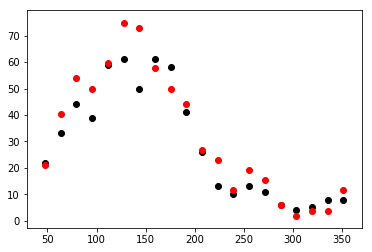

In [14]:
NUMU_R1_POT = 9.083e19
NUMU_R1_DATA_POT = 1.746e+20
RSE=['run','subrun','event']
df_mc = read_root('/media/disk1/kmason/mcc9_v29e_dl_run1_C1_part0_pi0_sideband_dlana_v1_1_4_fvv.root','dlana/FinalVertexVariables')
df_data = read_root('/media/disk1/kmason/data/mcc9_v29e_dl_run1_C1_bnb_dlfilter_pi0_v1_1_3_fvv.root','dlana/FinalVertexVariables')
print (len(df_data))

cuts = 'PassPMTPrecut ==1 and PassShowerReco ==1 and InFiducial ==1  and NTracks ==2 and Proton_Edep>60.0  and Electron_Edep>35.0  and shower1_E_Y>80 and ChargeNearTrunk >250 and Electron_ThetaRecoB_e1ep <1.5 and _shower_alpha <2.5  '
sort = 'shower1_E_Y'
df_data = df_data.query(cuts)
df_data = df_data.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_mc = df_mc.query(cuts)
df_mc = df_mc.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
print (len(df_data))

import matplotlib.pyplot as plt
# Make data plots, normalized
# checking to see if any bins look realyl off
var_r1 = df_data["_pi0mass"].values
var_r2 = df_mc["_pi0mass"].values
weights_v =[NUMU_R1_DATA_POT/float(NUMU_R1_POT) for i in range(len(var_r2))]

# turn into histograms
r1_Hist,binedges = np.histogram( var_r1, bins = 20, range = [30,350])
r2_Hist,binedges = np.histogram( var_r2, bins = 20, range = [30,350],weights=weights_v)
bincenters = np.ones(len(binedges)-1)
for i in range(len(binedges)-1):
    bincenters[i] = binedges[i]+(350.0/20.0)

# err_1 = [sqrt(float(i))/float(len(var_r1)) for i in r1_Hist]

plt.scatter(bincenters,r1_Hist,  marker='o', color = 'black')
plt.scatter(bincenters,r2_Hist,  marker='o', color = 'red')
plt.show()
plt.close()